In [100]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10, 10

In [101]:
data=pd.read_csv('data.csv', ';')
print(data)

      Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3   Unnamed: 4   Unnamed: 5  \
0           time         ax         ay         az     Latitude    Longitude   
1         0.0140    -2.0742    -3.7525    -3.0987   0.00000000   0.00000000   
2         0.0140    -2.0742    -3.7525    -3.0987   0.00000000   0.00000000   
3         0.0140    -3.1189    -4.3215    -3.4860   0.00000000   0.00000000   
4         0.0150    -3.1189    -4.3215    -3.4860   0.00000000   0.00000000   
5         0.0150    -3.1189    -4.3215    -3.4860   0.00000000   0.00000000   
6         0.0150    -3.1189    -4.3215    -3.4860   0.00000000   0.00000000   
7         0.0150    -2.7801    -4.3301    -0.1798   0.00000000   0.00000000   
8         0.0160    -2.7801    -4.3301    -0.1798   0.00000000   0.00000000   
9         0.0160    -2.7801    -4.3301    -0.1798   0.00000000   0.00000000   
10        0.0160    -2.7801    -4.3301    -0.1798   0.00000000   0.00000000   
11        0.0170    -6.0085    -1.9128     3.4016   

we drop the zero values at the beginning 

In [102]:
data=data.drop(data.index[0:1693])
data.reset_index(drop=True, inplace=True)

In [103]:
latitude=data[data.columns[4]].values.astype(float)
longitude=data[data.columns[5]].values.astype(float)
latitude=np.deg2rad(latitude)
longitude=np.deg2rad(longitude)
print(latitude)
print(longitude)

[0.97304318 0.97304318 0.97304318 ... 0.97305929 0.97305929 0.97305929]
[0.85070902 0.85070902 0.85070902 ... 0.85071471 0.85071471 0.85071471]


We calculate x, y z:

In [104]:
earthRadius = 6378100
x = earthRadius * np.cos(latitude)*np.cos(longitude)
y = earthRadius * np.cos(latitude)*np.sin(longitude)
z = earthRadius * np.sin(latitude)
x=x-x[0]
y=y-y[0]
z=z-z[0]
z=np.array([x, y, z])
z=z.T

We extract the time intervals and the acceleration:

In [105]:
time= data[data.columns[0]].values.astype(float)
time=time-time[0]
print(time)

[ 0.     0.     0.    ... 39.352 39.352 39.352]


In [110]:
acc=data[[data.columns[1], data.columns[2], data.columns[3]]].values.astype(float)
print(acc)

[[10.4298 -1.2206 -9.0779]
 [10.4298 -1.2206 -9.0779]
 [13.6652 -3.6922 -3.2072]
 ...
 [-1.1328 -0.1286  2.6163]
 [-1.1328 -0.1286  2.6163]
 [-1.2968  0.1154  3.1709]]


KALMAN FILTER ALGORITHM

In [107]:
def kalman(acc, z, time):
    R=np.array([[np.std(z[:, 0])**2, 0, 0], [0, np.std(z[:, 1])**2, 0], [0, 0, np.std(z[:, 2])**2]])
    Q=0.05*np.identity(6)
    #Q=0
    
    x=np.zeros([z.shape[0], 6])
    P=np.identity(6)
    
    for k in range(1, z.shape[0]):
        delta=time[k]-time[k-1]
        
        A= np.array([[1, 0, 0, delta, 0, 0], [0, 1, 0, 0, delta, 0], [0, 0, 1, 0, 0, delta], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
        B= np.array([[0.5*delta**2, 0, 0], [0, 0.5*delta**2, 0], [0, 0, 0.5*delta**2], [delta, 0, 0], [0, delta, 0], [0, 0, delta]])
        H= np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])
        
        x[k, :]=np.dot(A, x[k-1, :]) + np.dot(B, acc[k, :])
        P=np.dot(A, np.dot(P, A.T)) +Q
        
        K= P.dot( H.T.dot(inv(H.dot(P.dot(H.T)) + R)))
        
        x[k, :]= x[k, :] + K.dot(z[k, :] - H.dot(x[k, :]))
        
        P=(np.identity(6)-K.dot(H)).dot(P)
        
    return x

In [108]:
X=kalman(acc, z, time)

<function matplotlib.pyplot.show(*args, **kw)>

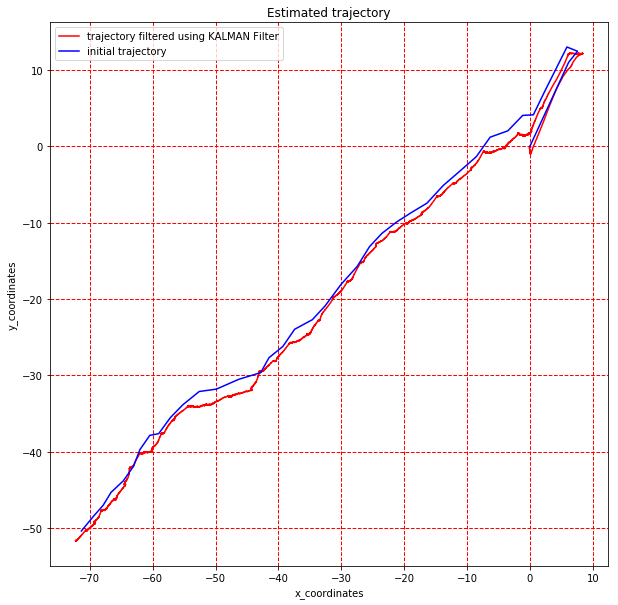

In [109]:
plt.figure()
plt.plot(X[:,0], X[:,1], color='red', label='trajectory filtered using KALMAN Filter')
plt.plot(x, y, color='blue', label='initial trajectory')
plt.grid(color='r', linestyle='--', linewidth=1)
plt.xlabel("x_coordinates")
plt.ylabel("y_coordinates")
plt.legend()
plt.title('Estimated trajectory')
plt.show

TASK 2 KINECT

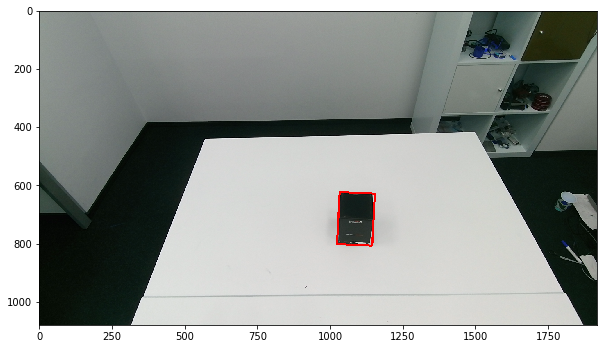

In [111]:
import cv2
import numpy as np


def center(pointA, pointB):
    return (pointA[0] + pointB[0]) * 0.5, (pointA[1] + pointB[1]) * 0.5

#importing the images
image = cv2.imread('RGB_image.bmp')
depth = cv2.imread('Depth_image.png')


#extracting the contour of the object
blurred = cv2.pyrMeanShiftFiltering(image, 21, 51)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
ret, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

_, contours, _ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
rectangle = None
for contour in contours:

    # get rectangle bounding contour

    [x, y, w, h] = cv2.boundingRect(contour)
    # discard areas that are too large
    if h > 150 and h < 190 and w > 120 and w < 130:
        rect = cv2.minAreaRect(contour)
        rectangle = cv2.boxPoints(rect)
        rectangle = np.int0(rectangle)
        cv2.drawContours(image, [rectangle], 0, (255, 0, 0), 6)
plt.imshow(image)


Center point in RGB image: 1090.0 714.5


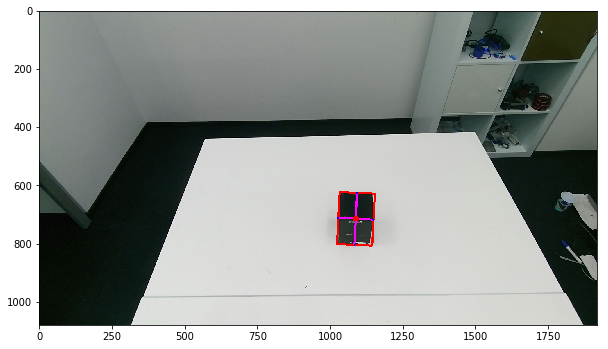

In [112]:
#calculating and plotting the center of the object
(bl_point, tl_point, tr_point, br_point) = rectangle
(top_point_x, top_point_y) = center(tl_point, tr_point)
(bottom_point_x, bottom_point_y) = center(bl_point, br_point)
(left_point_x, left_point_y) = center(tl_point, bl_point)
(right_point_x, right_point_y) = center(tr_point, br_point)

cv2.line(image, (int(top_point_x), int(top_point_y)), (int(bottom_point_x), int(bottom_point_y)), (255, 0, 255), 6)
cv2.line(image, (int(left_point_x), int(left_point_y)), (int(right_point_x), int(right_point_y)), (255, 0, 255), 6)

cv2.circle(image, (int(top_point_x), int(top_point_y)), 3, (0, 0, 255), -1)
cv2.circle(image, (int(bottom_point_x), int(bottom_point_y)), 3, (0, 0, 255), -1)
cv2.circle(image, (int(left_point_x), int(left_point_y)), 3, (0, 0, 255), -1)
cv2.circle(image, (int(right_point_x), int(right_point_y)), 3, (0, 0, 255), -1)

center_x = (top_point_x+bottom_point_x)/2
center_y = (left_point_y+right_point_y)/2

# we print and plot the center point in the RGB image
print("Center point in RGB image:", center_x, center_y)
cv2.circle(image, (int(center_x), int(center_y)), 10, (255, 0, 0), -1)
plt.imshow(image)


Center point in depth image: 290.6666666666667 280.5074074074074


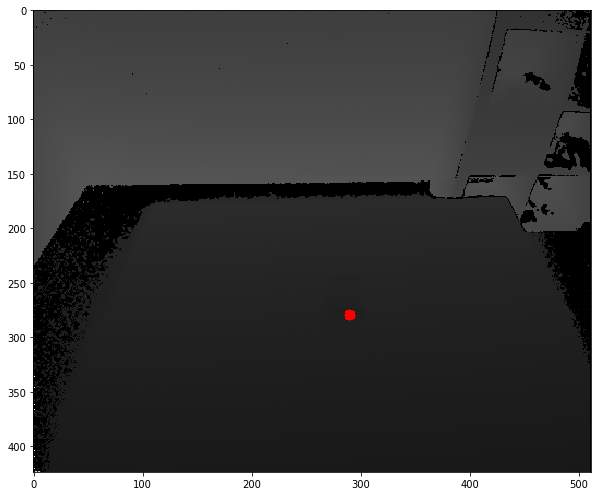

In [113]:
# we apply the formula point_Depth= point_RGB *resolution_Depth/resolution_RBG
center_x_depth = center_x*(512/1920)
center_y_depth = center_y*(424/1080)

# we print and plot the center point in the depth image
print("Center point in depth image:", center_x_depth, center_y_depth)
cv2.circle(depth, (int(center_x_depth), int(center_y_depth)), 5, (255, 0, 0), -1)
plt.imshow(depth)


We extract value of level of gray of the center point

In [95]:
print (depth[int(center_x_depth), int(center_y_depth)])

array([32, 32, 32], dtype=uint8)